In [23]:
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
from model.DIEN import DIEN
import data_reader.alibaba_data_reader as data_reader
import utils
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib.pyplot import MultipleLocator
import numpy as np

In [2]:
def is_in_notebook():
    import sys
    return 'ipykernel' in sys.modules
def clear_output():
    """
    clear output for both jupyter notebook and the console
    """
    import os
    os.system('cls' if os.name == 'nt' else 'clear')
    if is_in_notebook():
        from IPython.display import clear_output as clear
        clear()
def mkdir(path):
    try:
        if not os.path.exists(path):
            os.makedirs(path)
        return 0
    except:
        return 1
model_name = "dien"

In [3]:
print(tf.__version__)
print("GPU Available: ", tf.test.is_gpu_available())

2.0.0
GPU Available:  True


# 模型训练

In [4]:
train_data, test_data, embedding_count = data_reader.get_data()
embedding_count

,brand,cate,cms_segid,cms_group,gender,age,pvalue,shopping,occupation,user_class_level
0,460561,12968,97,13,2,7,3,3,2,4


In [5]:
embedding_features_list = data_reader.get_embedding_features_list()
user_behavior_features = data_reader.get_user_behavior_features()
embedding_count_dict = data_reader.get_embedding_count_dict(embedding_features_list, embedding_count)
embedding_dim_dict = data_reader.get_embedding_dim_dict(embedding_features_list)

In [8]:
import time
stamp = time.strftime("%Y%m%d-%H%M%S", time.localtime())
mkdir("./train_log/" + model_name)
log_path = "./train_log/"+model_name+"/%s" % stamp
train_summary_writer = tf.summary.create_file_writer(log_path)
tf.summary.trace_on(graph=True, profiler=True)
loss_file_name = utils.get_file_name()
mkdir("./loss/" + model_name + "/")
utils.make_train_loss_dir(loss_file_name, cols=["train_aux_loss","train_target_loss","train_final_loss"], model=model_name)
utils.make_test_loss_dir(loss_file_name, cols=["test_aux_loss","test_target_loss","test_final_loss"], model=model_name)

In [9]:
 model = DIEN(
    embedding_count_dict, 
    embedding_dim_dict, 
    embedding_features_list, 
    user_behavior_features, 
    activation="dice")
model

In [10]:
min_batch = 0
batch = 100
optimizer = tf.keras.optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
loss_metric = tf.keras.metrics.Sum()
auc_metric = tf.keras.metrics.AUC()
alpha = 1
epochs = 3

In [11]:
label, target_cate, target_brand, cms_segid, cms_group, gender, age, pvalue, shopping, occupation, user_class_level, hist_brand_behavior_clk, hist_cate_behavior_clk, hist_brand_behavior_show, hist_cate_behavior_show, min_batch, clk_length, show_length = data_reader.get_batch_data(train_data, min_batch, batch = batch)

In [12]:
def get_train_data(label, target_cate, target_brand, cms_segid, cms_group, gender, age, pvalue, shopping, occupation, user_class_level, hist_brand_behavior_clk, hist_cate_behavior_clk, hist_brand_behavior_show, hist_cate_behavior_show):
    user_profile_dict = {
        "cms_segid": cms_segid,
        "cms_group": cms_group,
        "gender": gender,
        "age": age,
        "pvalue": pvalue,
        "shopping": shopping,
        "occupation": occupation,
        "user_class_level": user_class_level
    }
    user_profile_list = ["cms_segid", "cms_group", "gender", "age", "pvalue", "shopping", "occupation", "user_class_level"]
    user_behavior_list = ["brand", "cate"]
    click_behavior_dict = {
        "brand": hist_brand_behavior_clk,
        "cate": hist_cate_behavior_clk
    }
    noclick_behavior_dict = {
        "brand": hist_brand_behavior_show,
        "cate": hist_cate_behavior_show
    }
    target_item_dict = {
        "brand": target_cate,
        "cate": target_brand
    }
    return user_profile_dict, user_profile_list, user_behavior_list, click_behavior_dict, noclick_behavior_dict, target_item_dict

In [13]:
user_profile_dict, user_profile_list, user_behavior_list, click_behavior_dict, noclick_behavior_dict, target_item_dict = get_train_data(label, target_cate, target_brand, cms_segid, cms_group, gender, age, pvalue, shopping, occupation, user_class_level, hist_brand_behavior_clk, hist_cate_behavior_clk, hist_brand_behavior_show, hist_cate_behavior_show) 

In [14]:
def train_one_step(user_profile_dict, user_profile_list, click_behavior_dict, target_item_dict, noclick_behavior_dict, user_behavior_list, label):
        with tf.GradientTape() as tape:
            output, logit, aux_loss = model(user_profile_dict, user_profile_list, click_behavior_dict, target_item_dict, noclick_behavior_dict, user_behavior_list)
            target_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logit,labels=tf.cast(label, dtype=tf.float32)))
            final_loss = target_loss + alpha * aux_loss
            #print("[Train Loss] aux_loss=" + str(aux_loss.numpy()) + ", target_loss=" + str(target_loss.numpy()) + ", final_loss=" + str(final_loss.numpy()))
        gradient = tape.gradient(final_loss, model.trainable_variables)
        clip_gradient, _ = tf.clip_by_global_norm(gradient, 5.0)
        optimizer.apply_gradients(zip(clip_gradient, model.trainable_variables))
        loss_metric(final_loss)
        return aux_loss.numpy(), target_loss.numpy(), final_loss.numpy()

In [15]:
def get_test_loss(user_profile_dict, user_profile_list, click_behavior_dict, target_item_dict, noclick_behavior_dict, user_behavior_list, label):
    output, logit, aux_loss = model(user_profile_dict, user_profile_list, click_behavior_dict, target_item_dict, noclick_behavior_dict, user_behavior_list)
    target_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logit,labels=tf.cast(label, dtype=tf.float32)))
    final_loss = target_loss + alpha * aux_loss
    #print("[Test Loss] aux_loss=" + str(aux_loss.numpy()) + ", target_loss=" + str(target_loss.numpy()) + ", final_loss=" + str(final_loss.numpy()))
    return aux_loss.numpy(), target_loss.numpy(), final_loss.numpy()

In [16]:
get_test_loss(user_profile_dict, user_profile_list, click_behavior_dict, target_item_dict, noclick_behavior_dict, user_behavior_list, label)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



(0.28114048, 0.69257253, 0.97371304)

In [17]:
model.summary()

Model: "dien"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      multiple                  448       
_________________________________________________________________
embedding_1 (Embedding)      multiple                  32000000  
_________________________________________________________________
embedding (Embedding)        multiple                  32100992  
_________________________________________________________________
embedding_3 (Embedding)      multiple                  832       
_________________________________________________________________
embedding_2 (Embedding)      multiple                  6208      
_________________________________________________________________
embedding_4 (Embedding)      multiple                  192       
_________________________________________________________________
embedding_8 (Embedding)      multiple                  320    

In [18]:
 for var in model.trainable_variables:
    print(var.name)

dien/embedding_5/embeddings:0
dien/embedding_1/embeddings:0
dien/embedding/embeddings:0
dien/embedding_3/embeddings:0
dien/embedding_2/embeddings:0
dien/embedding_4/embeddings:0
dien/embedding_8/embeddings:0
dien/embedding_6/embeddings:0
dien/embedding_7/embeddings:0
dien/embedding_9/embeddings:0
dien/gru/kernel:0
dien/gru/recurrent_kernel:0
dien/gru/bias:0
dien/aux_layer/sequential/batch_normalization/gamma:0
dien/aux_layer/sequential/batch_normalization/beta:0
dien/aux_layer/sequential/dense/kernel:0
dien/aux_layer/sequential/dense/bias:0
dien/aux_layer/sequential/dense_1/kernel:0
dien/aux_layer/sequential/dense_1/bias:0
dien/aux_layer/sequential/dense_2/kernel:0
dien/aux_layer/sequential/dense_2/bias:0
dien/augru/gru_gates/dense_3/kernel:0
dien/augru/gru_gates/dense_3/bias:0
dien/augru/gru_gates/dense_4/kernel:0
dien/augru/gru_gates_1/dense_5/kernel:0
dien/augru/gru_gates_1/dense_5/bias:0
dien/augru/gru_gates_1/dense_6/kernel:0
dien/augru/gru_gates_2/dense_7/kernel:0
dien/augru/gru_

In [19]:
def get_loss_fig(train_loss, test_loss):
    loss_list = ["aux_loss", "final_loss"]
    color_list = ["r", "b"]
    plt.figure()
    cnt = 0
    for k in loss_list:
        loss = train_loss[k]
        step = list(np.arange(len(loss)))
        plt.plot(step,loss,color_list[cnt]+"-",label="train_" + k, linestyle="--")
        cnt += 1
    cnt = 0
    for k in loss_list:
        loss = test_loss[k]
        step = list(np.arange(len(loss)))
        plt.plot(step,loss,color_list[cnt],label="test_" + k)
        cnt += 1
    plt.title("Loss")
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.legend()
    clear_output()
    plt.savefig("./loss/" + model_name + "/loss.png")
    clear_output()
    plt.show()

In [20]:
def record_test_loss(test_loss, test_data, step):
    label, target_cate, target_brand, cms_segid, cms_group, gender, age, pvalue, shopping, occupation, user_class_level, hist_brand_behavior_clk, hist_cate_behavior_clk, hist_brand_behavior_show, hist_cate_behavior_show, clk_length, show_length = data_reader.get_test_data(test_data)
    user_profile_dict, user_profile_list, user_behavior_list, click_behavior_dict, noclick_behavior_dict, target_item_dict = get_train_data(label, target_cate, target_brand, cms_segid, cms_group, gender, age, pvalue, shopping, occupation, user_class_level, hist_brand_behavior_clk, hist_cate_behavior_clk, hist_brand_behavior_show, hist_cate_behavior_show)
    aux_loss, target_loss, final_loss = get_test_loss(user_profile_dict, user_profile_list, click_behavior_dict, target_item_dict, noclick_behavior_dict, user_behavior_list, label)
    loss_dict = dict()
    loss_dict["aux_loss"] = str(aux_loss)
    loss_dict["target_loss"] = str(target_loss)
    loss_dict["final_loss"] = str(final_loss)
    utils.add_loss(loss_dict, loss_file_name, level="test")
    test_loss["aux_loss"].append(float(aux_loss))
    test_loss["target_loss"].append(float(target_loss))
    test_loss["final_loss"].append(float(final_loss))
    with train_summary_writer.as_default():
        tf.summary.scalar("test_aux_loss epoch: "+str(epoch), aux_loss, step = step)
        tf.summary.scalar("test_target_loss epoch: "+str(epoch), target_loss, step = step)
        tf.summary.scalar("test_final_loss epoch: "+str(epoch), final_loss, step = step)

In [21]:
mkdir("./checkpoint/" + model_name)
checkpoint_path = "./checkpoint/" + model_name + "/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

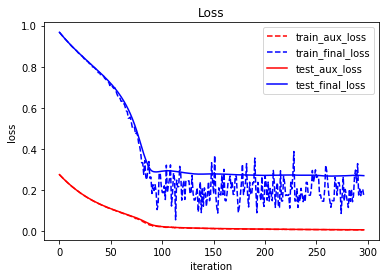

In [24]:
train_loss = {"aux_loss":[], "target_loss":[], "final_loss":[]}
test_loss = {"aux_loss":[], "target_loss":[], "final_loss":[]}
for epoch in range(epochs):
    for i in range(int(len(train_data) / batch)):
        record_test_loss(test_loss, test_data, i)
        label, target_cate, target_brand, cms_segid, cms_group, gender, age, pvalue, shopping, occupation, user_class_level, hist_brand_behavior_clk, hist_cate_behavior_clk, hist_brand_behavior_show, hist_cate_behavior_show, min_batch, clk_length, show_length = data_reader.get_batch_data(train_data, min_batch, batch = batch)
        user_profile_dict, user_profile_list, user_behavior_list, click_behavior_dict, noclick_behavior_dict, target_item_dict = get_train_data(label, target_cate, target_brand, cms_segid, cms_group, gender, age, pvalue, shopping, occupation, user_class_level, hist_brand_behavior_clk, hist_cate_behavior_clk, hist_brand_behavior_show, hist_cate_behavior_show)
        aux_loss, target_loss, final_loss = train_one_step(user_profile_dict, user_profile_list, click_behavior_dict, target_item_dict, noclick_behavior_dict, user_behavior_list, label)
        #Record_loss12
        loss_dict = dict()
        loss_dict["aux_loss"] = str(aux_loss)
        loss_dict["target_loss"] = str(target_loss)
        loss_dict["final_loss"] = str(final_loss)
        utils.add_loss(loss_dict, loss_file_name, level="train")
        train_loss["aux_loss"].append(float(aux_loss))
        train_loss["target_loss"].append(float(target_loss))
        train_loss["final_loss"].append(float(final_loss))
        get_loss_fig(train_loss, test_loss)
        tf.summary.trace_on(graph=True, profiler=True)
        with train_summary_writer.as_default():
            tf.summary.scalar("train_aux_loss epoch: "+str(epoch), aux_loss, step = i)
            tf.summary.scalar("train_target_loss epoch: "+str(epoch), target_loss, step = i)
            tf.summary.scalar("train_final_loss epoch: "+str(epoch), final_loss, step = i)
            tf.summary.trace_export(
                name="DIEN", 
                step=i, 
                profiler_outdir=log_path)
    model.save_weights(checkpoint_path.format(epoch=epoch))

# 模型评估

In [26]:
last_model = DIEN(embedding_count_dict, embedding_dim_dict, embedding_features_list, user_behavior_features, activation="dice")
latest = tf.train.latest_checkpoint(checkpoint_dir)
print(latest)
last_model.load_weights(latest)

./checkpoint/dien/cp-0002.ckpt


In [27]:
model= last_model
label, target_cate, target_brand, cms_segid, cms_group, gender, age, pvalue, shopping, occupation, user_class_level, hist_brand_behavior_clk, hist_cate_behavior_clk, hist_brand_behavior_show, hist_cate_behavior_show, clk_length, show_length = data_reader.get_test_data(test_data)
user_profile_dict, user_profile_list, user_behavior_list, click_behavior_dict, noclick_behavior_dict, target_item_dict = get_train_data(label, target_cate, target_brand, cms_segid, cms_group, gender, age, pvalue, shopping, occupation, user_class_level, hist_brand_behavior_clk, hist_cate_behavior_clk, hist_brand_behavior_show, hist_cate_behavior_show)
aux_loss, target_loss, final_loss = get_test_loss(user_profile_dict, user_profile_list, click_behavior_dict, target_item_dict, noclick_behavior_dict, user_behavior_list, label)
aux_loss, target_loss, final_loss


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



(0.0073707164, 0.26306152, 0.27043223)

In [28]:
def convert_tensor(data):
    return tf.convert_to_tensor(data)

def get_normal_data(data, col):
    return data[col].values

def get_sequence_data(data, col):
    rst = []
    max_length = 0
    for i in data[col].values:
        temp = len(list(map(eval,i[1:-1].split(","))))
        if temp > max_length:
            max_length = temp

    for i in data[col].values:
        temp = list(map(eval,i[1:-1].split(",")))
        padding = np.zeros(max_length - len(temp))
        rst.append(list(np.append(np.array(temp), padding)))
    return rst

def get_evaluate_data(data):
    batch_data = data
    click = get_normal_data(batch_data, "guide_dien_final_train_data.clk")
    target_cate = get_normal_data(batch_data, "guide_dien_final_train_data.cate_id")
    target_brand = get_normal_data(batch_data, "guide_dien_final_train_data.brand")
    cms_segid = get_normal_data(batch_data, "guide_dien_final_train_data.cms_segid")
    cms_group = get_normal_data(batch_data, "guide_dien_final_train_data.cms_group_id")
    gender = get_normal_data(batch_data, "guide_dien_final_train_data.final_gender_code")
    age = get_normal_data(batch_data, "guide_dien_final_train_data.age_level")
    pvalue = get_normal_data(batch_data, "guide_dien_final_train_data.pvalue_level")
    shopping = get_normal_data(batch_data, "guide_dien_final_train_data.shopping_level")
    occupation = get_normal_data(batch_data, "guide_dien_final_train_data.occupation")
    user_class_level = get_normal_data(batch_data, "guide_dien_final_train_data.new_user_class_level")
    hist_brand_behavior_clk = get_sequence_data(batch_data, "guide_dien_final_train_data.click_brand")
    hist_cate_behavior_clk = get_sequence_data(batch_data, "guide_dien_final_train_data.click_cate")
    hist_brand_behavior_show = get_sequence_data(batch_data, "guide_dien_final_train_data.show_brand")
    hist_cate_behavior_show = get_sequence_data(batch_data, "guide_dien_final_train_data.show_cate")
    return tf.one_hot(click, 2), convert_tensor(target_cate), convert_tensor(target_brand), convert_tensor(cms_segid), convert_tensor(cms_group), convert_tensor(gender), convert_tensor(age), convert_tensor(pvalue), convert_tensor(shopping), convert_tensor(occupation), convert_tensor(user_class_level), convert_tensor(hist_brand_behavior_clk), convert_tensor(hist_cate_behavior_clk), convert_tensor(hist_brand_behavior_show), convert_tensor(hist_cate_behavior_show)

In [29]:
label, target_cate, target_brand, cms_segid, cms_group, gender, age, pvalue, shopping, occupation, user_class_level, hist_brand_behavior_clk, hist_cate_behavior_clk, hist_brand_behavior_show, hist_cate_behavior_show = get_evaluate_data(test_data)
user_profile_dict, user_profile_list, user_behavior_list, click_behavior_dict, noclick_behavior_dict, target_item_dict = get_train_data(label, target_cate, target_brand, cms_segid, cms_group, gender, age, pvalue, shopping, occupation, user_class_level, hist_brand_behavior_clk, hist_cate_behavior_clk, hist_brand_behavior_show, hist_cate_behavior_show)
output, logit, aux_loss = model(user_profile_dict, user_profile_list, click_behavior_dict, target_item_dict, noclick_behavior_dict, user_behavior_list)

In [30]:
train_label = train_data["guide_dien_final_train_data.clk"].values
positive_num = len(train_label[train_label == 1])
negative_num = len(train_label[train_label == 0])
print("[训练集]正例:负例=%d : %d" % (positive_num, negative_num))
test_label = test_data["guide_dien_final_train_data.clk"].values
positive_num = len(test_label[test_label == 1])
negative_num = len(test_label[test_label == 0])
print("[测试集]正例:负例=%d : %d" % (positive_num, negative_num))

[训练集]正例:负例=501 : 9435
[测试集]正例:负例=56 : 943


In [31]:
y_true = label.numpy()[:,-1]
y_score = output.numpy()[:,-1]

In [32]:
threshold = 0.0031
y_pre = y_score.copy()
y_pre[y_pre > threshold] = 1
y_pre[y_pre <= threshold] = 0

In [33]:
 import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc
import sklearn.metrics as sm
from sklearn.metrics import roc_curve, auc
import matplotlib as mpl  
import matplotlib.pyplot as plt

In [34]:
 print(accuracy_score(y_true, y_pre))

0.9229229229229229


In [35]:
m = sm.confusion_matrix(y_true, y_pre)
print('混淆矩阵为：', m, sep='\n')

混淆矩阵为：
[[918  25]
 [ 52   4]]


In [36]:
 r = sm.classification_report(y_true, y_pre)
print('分类报告为：', r, sep='\n')

分类报告为：
              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96       943
         1.0       0.14      0.07      0.09        56

    accuracy                           0.92       999
   macro avg       0.54      0.52      0.53       999
weighted avg       0.90      0.92      0.91       999



In [37]:
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(y_true,y_score)
auc_score

0.6558665353734283

In [38]:
def plot_roc(labels, predict_prob):
    false_positive_rate,true_positive_rate,thresholds=roc_curve(labels, predict_prob)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    plt.title('ROC')
    plt.plot(false_positive_rate, true_positive_rate,'b',label='AUC = %0.4f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    plt.show()

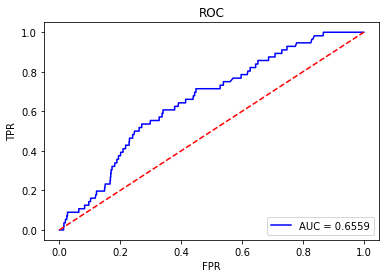

In [39]:
plot_roc(y_true, y_score)

# 整体训练图像

In [42]:
train_loss_data = pd.read_csv("./loss/dien/train_loss.csv.2020_10_09_20_28_53")
train_loss_data 

,train_aux_loss,train_target_loss,train_final_loss
0,0.281158,0.692724,0.973882
1,0.275765,0.691859,0.967625
2,0.270495,0.691288,0.961783
3,0.265310,0.690194,0.955503
4,0.260197,0.689377,0.949574
...,...,...,...
293,0.007479,0.198275,0.205754
294,0.007778,0.165749,0.173527
295,0.007124,0.193089,0.200213
296,0.007054,0.197869,0.204923


In [43]:
test_loss_data = pd.read_csv("./loss/dien/test_loss.csv.2020_10_09_20_28_53")
test_loss_data

,test_aux_loss,test_target_loss,test_final_loss
0,0.280888,0.692583,0.973471
1,0.275565,0.691791,0.967356
2,0.270332,0.691037,0.961369
3,0.265190,0.690260,0.955450
4,0.260140,0.689471,0.949611
...,...,...,...
293,0.007482,0.264175,0.271657
294,0.007460,0.263879,0.271339
295,0.007437,0.263652,0.271089
296,0.007415,0.263432,0.270847


In [44]:
def get_loss_fig_aux(train_loss_data, test_loss_data):
    train_loss = {
        "aux_loss":list(train_loss_data["train_" + "aux_loss"].values), 
        "target_loss":list(train_loss_data["train_" + "target_loss"].values), 
        "final_loss":list(train_loss_data["train_" + "final_loss"].values)
    }
    test_loss = {
        "aux_loss":list(test_loss_data["test_" + "aux_loss"].values), 
        "target_loss":list(test_loss_data["test_" + "target_loss"].values), 
        "final_loss":list(test_loss_data["test_" + "final_loss"].values)
    }
    get_loss_fig(train_loss, test_loss)

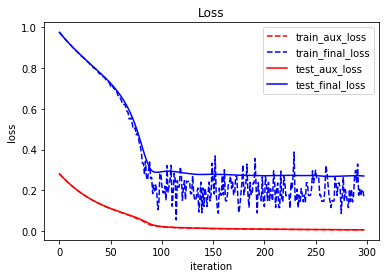

In [45]:
get_loss_fig_aux(train_loss_data, test_loss_data)